In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter foldername
FOLDERNAME = 'cs231n/DeepDoughnut'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Ensures Python interpreter of Colab VM can load python files.
import sys
sys.path.append('/content/drive/Shared drives/{}'.format(FOLDERNAME))

#Set your path
path='/content/drive/Shared drives/DeepDoughnut'


Mounted at /content/drive


In [ ]:
! pip install transformers datasets

In [3]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib as plt
import os
from scipy.io import loadmat

In [4]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [5]:
from torchvision.datasets import DatasetFolder

In [6]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [139]:
! find unzipped_images/. -maxdepth 1 -type f | head -10000 | xargs cp -t new_folder

In [17]:
def npy_loader(path):
  sample = torch.from_numpy(np.load(path))
  return sample 

dataset = DatasetFolder(
    root = path + "/sample", 
    loader = npy_loader, 
    extensions = ['.jpg.npy']
)

In [19]:
class ImageClassificationCollator:
   def __init__(self, feature_extractor): 
      self.feature_extractor = feature_extractor
      
   def __call__(self, batch):  
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')   
      encodings['labels'] = torch.tensor([x[1] for x in batch],    
      dtype=torch.long)
      return encodings

In [38]:
import math 
collator_fn = ImageClassificationCollator(feature_extractor)
indices = torch.randperm(len(dataset)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(dataset, indices[:-n_val])
val_ds = torch.utils.data.Subset(dataset, indices[-n_val:])

train_dl = DataLoader(train_ds, batch_size=4, collate_fn=collator_fn, shuffle = 1)
val_dl = DataLoader(val_ds, batch_size=4, collate_fn=collator_fn, shuffle=0)

In [7]:
class cityStreetsDataset(Dataset):

  def __init__(self, X, y):
    super().__init__()
    self.X = torch.Tensor(X)
    self.y = y
    
  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    #image_dict = feature_extractor(self.X[index], return_tensors='pt')
    image_dict = {}
    image_dict['pixel_values'] = self.X[index]
    image_dict['labels'] = self.y[index]
    # note already transformed so don't need to add transform right now 
    # X = self.X[index]
    # y = self.y[index]
    #return X, y
    return image_dict
  

In [8]:
# load data 
# with open(path + "/y_lab_array.pickle", 'rb') as f:
#   y_label = pickle.load(f)

# with open(path + "/imgs_array.pickle", 'rb') as f:
#   X_feat = pickle.load(f)

# if not pickled 
import zipfile
from PIL import Image
import numpy as np
from tqdm import tqdm 

X = []
y_label = []

#zip_folders=['part1.zip', 'part2.zip', 'part3.zip']
zip_folders = ['part1.zip']

for zip_folder in zip_folders:
  file_name=os.path.join(path, 'UCF_image_data', zip_folder)
  with zipfile.ZipFile(file_name, "r") as zip_data:
    content_list = zip_data.namelist()
    for i in tqdm(range(1, len(content_list), 30)):
        name_file=content_list[i]
        img_bytes = zip_data.open(name_file)          # 1
        img_data = Image.open(img_bytes)
        image_as_array = np.array(img_data, np.uint8) # 3
        X.append(image_as_array)
        y_label.append(int(name_file.split('_')[0]))

#X = np.array(X)
y_label = np.array(y_label)

100%|██████████| 220/220 [00:44<00:00,  4.99it/s]


In [9]:
#get labels from y_lab
labels = pd.read_csv(os.path.join(path, 'output_data/ucf_lat_lon_interpolated.csv'))
labels.set_index('merge_col')
labels['label_discrete']=labels.pred_post_pct_change.astype(str).str[:6]
labels['label_continuous']=labels.pred_post_pct_change
labels['label_ordinal'] = pd.cut(labels.pred_post_pct_change, 10, labels=False)
labels['label_positive'] = (labels.pred_post_pct_change>0).astype(int)

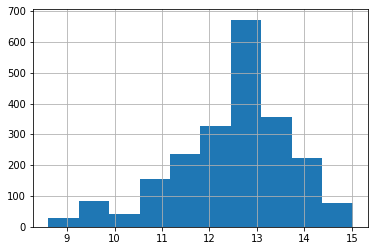

In [52]:
labels.loc[y_label]['pred_post_pct_change'].hist()

In [10]:
# if classification

y = pd.cut(labels.loc[y_label, 'pred_post_pct_change'], 6, labels=False) 
y = y.astype("category").cat.rename_categories([i for i in range(len(set(y)))])
y = np.array(y)

# if continuous 
# y = labels.loc[y_label, 'pred_post_pct_change']
# y = np.array(y)
y

array([5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 3, 3, 3, 3, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 5, 4, 4, 4, 4, 3, 3, 5, 4, 4, 4, 4, 3, 3, 2, 2, 2, 1,
       1, 0, 0, 0, 0, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 5, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 5, 5, 5, 5, 4, 4, 4,
       4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 4,
       4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4])

In [11]:
# slip to train, val, test 
from sklearn.model_selection import train_test_split

rseed = 231
#X_feat = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rseed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=rseed) 

In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [13]:
X_train_feat = feature_extractor(X_train, return_tensors='pt')['pixel_values']
X_val_feat = feature_extractor(X_val, return_tensors='pt')['pixel_values']

In [14]:
batch_size = 16 
train_ds = cityStreetsDataset(np.array(X_train_feat), torch.Tensor(np.array(y_train)).float())
#train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
val_ds = cityStreetsDataset(np.array(X_val_feat), torch.Tensor(np.array(y_val)).float())
#val_dl = DataLoader(val_ds, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

In [113]:
from torch.utils.data import TensorDataset

In [ ]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [109]:
train_ds2.set_transform(train_transforms)

AttributeError: ignored

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break
    
show_batch(train_dl)

In [126]:
batch = next(iter(train_dl))
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])


AttributeError: ignored

In [50]:
y_train.value_counts()

8    63
7    58
6    11
Name: label_ordinal, dtype: int64

In [39]:
# load the model 
from transformers import ViTForImageClassification

# if classification 

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=4
                                                  )

# if regression 

# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
#                                                   num_labels = 1)
# model.classifier = torch.nn.Linear(768, 1)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
os.chdir(path)

In [23]:
EPOCHS = 3
BATCH_SIZE = 10
LEARNING_RATE = 2e-5
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [41]:
labels

tensor([1, 1, 0, 0])

In [43]:
for i, batch in enumerate(tqdm(train_dl)): 
  optimizer.zero_grad()
  inputs, labels = batch['pixel_values'], batch['labels'] 
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs)
  loss = loss_func(outputs['logits'], labels)
  print(loss)

  9%|▉         | 1/11 [00:02<00:24,  2.42s/it]

tensor(1.3593, grad_fn=<NllLossBackward0>)


 18%|█▊        | 2/11 [00:04<00:22,  2.48s/it]

tensor(1.4210, grad_fn=<NllLossBackward0>)


 27%|██▋       | 3/11 [00:06<00:16,  2.11s/it]

tensor(1.3710, grad_fn=<NllLossBackward0>)


 36%|███▋      | 4/11 [00:08<00:12,  1.84s/it]

tensor(1.3359, grad_fn=<NllLossBackward0>)


 45%|████▌     | 5/11 [00:09<00:10,  1.70s/it]

tensor(1.3796, grad_fn=<NllLossBackward0>)


 55%|█████▍    | 6/11 [00:10<00:08,  1.60s/it]

tensor(1.4281, grad_fn=<NllLossBackward0>)


 64%|██████▎   | 7/11 [00:12<00:06,  1.55s/it]

tensor(1.4554, grad_fn=<NllLossBackward0>)


 73%|███████▎  | 8/11 [00:13<00:04,  1.52s/it]

tensor(1.3951, grad_fn=<NllLossBackward0>)


 82%|████████▏ | 9/11 [00:15<00:02,  1.49s/it]

tensor(1.3775, grad_fn=<NllLossBackward0>)


 91%|█████████ | 10/11 [00:16<00:01,  1.47s/it]

tensor(1.2998, grad_fn=<NllLossBackward0>)


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]

tensor(1.4459, grad_fn=<NllLossBackward0>)


In [23]:
from torch.autograd import Variable
print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(val_ds))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader  = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(val_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

Number of train samples:  132
Number of test samples:  44


ValueError: ignored

In [24]:
output = model(b_x)
output['logits']

tensor([[-0.0731, -0.0808,  0.0352],
        [-0.0035, -0.0573,  0.0694],
        [ 0.0361, -0.1717, -0.0366],
        [-0.0518, -0.0312,  0.0296],
        [-0.0623,  0.0512, -0.0723],
        [-0.0669, -0.1133,  0.0564],
        [-0.1793, -0.1326,  0.1225],
        [-0.0204, -0.0962, -0.1313],
        [ 0.0587,  0.1230, -0.0307],
        [ 0.0068, -0.1155, -0.1347]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [25]:
b_y

tensor([2, 1, 2, 1, 2, 2, 1, 1, 2, 2], device='cuda:0')

In [26]:
loss_func(output['logits'], b_y)

tensor(1.1154, device='cuda:0', grad_fn=<NllLossBackward0>)

In [115]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [116]:
from transformers import TrainingArguments, Trainer

#metric_name = "accuracy"
metric_name = "mse"

args = TrainingArguments(
    f"model",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    #metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [117]:
from datasets import load_metric
import numpy as np

# metric = load_metric("accuracy")

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return metric.compute(predictions=predictions, references=labels)


metric = load_metric("mse")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return metric.compute(predictions=predictions, references=labels)

In [118]:
import torch

class RegressionTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = nn.MSELoss()
    loss = loss_fct(logits.squeeze(), labels.squeeze())
    return (loss, outputs) if return_outputs else loss 

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics, 
    tokenizer=feature_extractor
)

# trainer = RegressionTrainer(
#     model,
#     args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     data_collator=collate_fn,
#     #compute_metrics=compute_metrics, 
#     tokenizer=feature_extractor
# )

In [119]:
model.num_labels

1

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [121]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1483
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 930


Epoch,Training Loss,Validation Loss,Mse
1,No log,1.544575,1.544575
2,No log,1.700119,1.700119
3,No log,1.623547,1.623547
4,No log,1.684042,1.684042
5,No log,1.678632,1.678632
6,1.309900,1.657197,1.657197
7,1.309900,1.744281,1.744281
8,1.309900,1.816873,1.816873
9,1.309900,1.879781,1.879781
10,1.309900,1.870313,1.870313


***** Running Evaluation *****
  Num examples = 495
  Batch size = 16
Saving model checkpoint to model/checkpoint-93
Configuration saved in model/checkpoint-93/config.json
Model weights saved in model/checkpoint-93/pytorch_model.bin
Feature extractor saved in model/checkpoint-93/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 495
  Batch size = 16
Saving model checkpoint to model/checkpoint-186
Configuration saved in model/checkpoint-186/config.json
Model weights saved in model/checkpoint-186/pytorch_model.bin
Feature extractor saved in model/checkpoint-186/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 495
  Batch size = 16
Saving model checkpoint to model/checkpoint-279
Configuration saved in model/checkpoint-279/config.json
Model weights saved in model/checkpoint-279/pytorch_model.bin
Feature extractor saved in model/checkpoint-279/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 495
  Batch size = 16
Saving 

TrainOutput(global_step=930, training_loss=1.1940047725554435, metrics={'train_runtime': 372.0692, 'train_samples_per_second': 39.858, 'train_steps_per_second': 2.5, 'total_flos': 1.149195906012672e+18, 'train_loss': 1.1940047725554435, 'epoch': 10.0})

In [122]:
outputs = trainer.predict(val_ds)

***** Running Prediction *****
  Num examples = 495
  Batch size = 16


In [108]:
outputs.metrics

{'test_loss': 1.5734572410583496,
 'test_mse': 1.5734572214913374,
 'test_runtime': 3.3151,
 'test_samples_per_second': 149.316,
 'test_steps_per_second': 9.351}

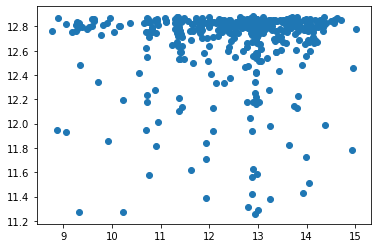

In [125]:
y_true = outputs.label_ids.squeeze()
y_pred = outputs.predictions.squeeze()

import matplotlib.pyplot as plt

plt.scatter(y_true, y_pred)

In [79]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:1000]', 'test[:200]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F9291E32210>,
 'label': 7,
 'pixel_values': tensor([[[ 0.3020,  0.3020,  0.3020,  ..., -0.2235, -0.2235, -0.2235],
          [ 0.3020,  0.3020,  0.3020,  ..., -0.2235, -0.2235, -0.2235],
          [ 0.3020,  0.3020,  0.3020,  ..., -0.2235, -0.2235, -0.2235],
          ...,
          [ 0.3490,  0.3490,  0.3490,  ..., -0.2549, -0.2549, -0.2549],
          [ 0.3490,  0.3490,  0.3490,  ..., -0.2549, -0.2549, -0.2549],
          [ 0.3490,  0.3490,  0.3490,  ..., -0.2549, -0.2549, -0.2549]],
 
         [[ 0.2941,  0.2941,  0.2941,  ..., -0.1529, -0.1529, -0.1529],
          [ 0.2941,  0.2941,  0.2941,  ..., -0.1529, -0.1529, -0.1529],
          [ 0.2941,  0.2941,  0.2941,  ..., -0.1529, -0.1529, -0.1529],
          ...,
          [ 0.3176,  0.3176,  0.3176,  ..., -0.2941, -0.2941, -0.2941],
          [ 0.3176,  0.3176,  0.3176,  ..., -0.2941, -0.2941, -0.2941],
          [ 0.3176,  0.3176,  0.3176,  ..., -0.2941, -0.294

In [80]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [81]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [82]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [83]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [84]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truc

In [85]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"model",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [86]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [87]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [88]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 900
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 270


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
! pip install transformers datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import os
from scipy.io import loadmat

In [ ]:
from transformers import ViTModel, ViTConfig

In [ ]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [ ]:
import zipfile
from PIL import Image
import numpy as np

X = []
y_label = []

#zip_folders=['part1.zip', 'part2.zip', 'part3.zip', 'part4.zip', 'part10.zip']
zip_folders=['part1.zip', 'part2.zip', 'part3.zip']
for zip_folder in zip_folders:
  file_name=os.path.join(path, 'UCF_image_data', zip_folder)
  with zipfile.ZipFile(file_name, "r") as zip_data:
    content_list = zip_data.namelist()
    for i in range(1, len(content_list), 30):
        name_file=content_list[i]
        img_bytes = zip_data.open(name_file)          # 1
        img_data = Image.open(img_bytes)
        #img_data = Image.open(img_bytes).resize((224, 224), resample=0)             # 2
        # ndarray with shape=(1024, 1280, 3)
        image_as_array = np.array(img_data, np.uint8) # 3
        #image_reshaped = np.array([rebin(image_as_array[:, :, 0], (32, 32)), rebin(image_as_array[:, :, 1], (32, 32)), rebin(image_as_array[:, :, 2], (32, 32))])
        #image_reshaped=image_reshaped.transpose([1, 2, 0])
        X.append(image_as_array)
        y_label.append(int(name_file.split('_')[0]))

In [ ]:
# define transforms 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
#get labels from y_lab
labels = pd.read_csv(os.path.join(path, 'output_data/ucf_lat_lon_geocoded_with_outcomes.csv'))
labels['change_in_growth_rate']=labels['post_pct_change']-labels['pre_pct_change']
labels.set_index('merge_col')
labels['label_discrete']=labels.change_in_growth_rate.astype(str).str[:6]
labels['label_continuous']=labels.change_in_growth_rate
labels['label_ordinal'] = pd.cut(labels.change_in_growth_rate, 10, labels=False)
labels['label_positive'] = (labels.change_in_growth_rate>0).astype(int)
y = labels.loc[y_label, 'label_ordinal']

In [ ]:
np.unique(labels.loc[y_label, 'label_continuous'], return_counts=True)

(array([ 0.56509595,  2.69854028,  5.4423697 , 10.57110052]),
 array([ 44,  62, 522,  32]))

In [ ]:
X_train[0]

In [ ]:
X_train_tensors['pixel_values'][0]

In [ ]:
from sklearn.model_selection import train_test_split

rseed = 231
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

X_train_tensors = feature_extractor(X_train, return_tensors='pt')
X_train_tensors['labels'] = y_train

In [ ]:
X_test_tensors = feature_extractor(X_test, return_tensors='pt')
X_test_tensors['labels'] = y_test

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1), 
        references=p.label_ids
      )

In [ ]:
from datasets import load_dataset

ds = load_dataset('beans')

Using custom data configuration default


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
np.unique(y_test)

array([3., 5., 6., 9.])

In [ ]:
from transformers import ViTForImageClassification

In [ ]:
unique_y = np.unique(y)

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(unique_y),
    id2label={str(i): c for i, c in enumerate(unique_y)},
    label2id={c: str(i) for i, c in enumerate(unique_y)}
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import create_optimizer

num_train_epochs = 4
num_train_steps = len(X_train_tensors['pixel_values']) * num_train_epochs

In [ ]:
train_batch_size = 16
eval_batch_size = 16
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

In [ ]:
import torch.nn as nn 

In [ ]:
os.chdir(path)

In [ ]:
os.getcwd()

'/content/drive/Shareddrives/DeepDoughnut'

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="/model",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  #report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=X_train_tensors,
    eval_dataset=X_test_tensors,
    tokenizer=feature_extractor,
)

Using amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4


KeyError: ignored

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

KNN with discrete labels

In [ ]:
from sklearn.model_selection import train_test_split
#.6, .2, .2
y=labels.loc[y_label, 'label_ordinal']
X_tmp = X[np.logical_not(np.isnan(y))]
y = y[np.logical_not(np.isnan(y))]

X_train, X_test, y_train, y_test = train_test_split(X_tmp, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

In [ ]:
# Create a kNN classifier instance. 
from sklearn.neighbors import KNeighborsClassifier
# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
model = KNeighborsClassifier()
model.fit(X_train, y_train)
acc = model.score(X_val, y_val)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 97.42%


In [ ]:
#Create an SVM classifier
from sklearn.svm import SVC
# train and evaluate an SVM
print("[INFO] evaluating raw pixel accuracy...")
model = SVC(class_weight='balanced')
model.fit(X_train, y_train)
acc = model.score(X_val, y_val)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 97.42%


Regression with continuous labels

In [ ]:
from sklearn.model_selection import train_test_split
#.6, .2, .2
#X = X[np.logical_not(np.isnan(y_label["label_continuous"]))]
y=labels.loc[y_label, 'label_continuous']
y = y[np.logical_not(np.isnan(y))]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

np.sqrt(np.mean( (y_val_pred - y_val)**2 ))

3.5420976683998506

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, random_state = 231)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

np.sqrt(np.mean( (y_val_pred - y_val)**2 ))

2.297891973953032

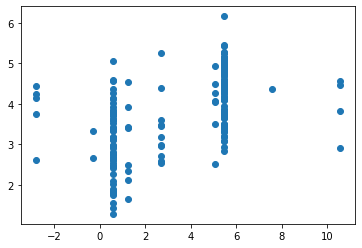

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_val, y_val_pred)

In [ ]:
y.value_counts()

 5.442370     522
 0.565096     264
 2.698540      62
 10.571101     32
 1.237649      23
-2.810736      17
 5.065823      17
 7.581482      10
 1.254648       7
-0.305964       3
Name: label_continuous, dtype: int64

# Vision Transformer

In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 9.5 MB/s 
     |████████████████████████████████| 140 kB 91.7 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 82.2 MB/s 
     |████████████████████████████████| 212 kB 97.8 MB/s 
     |████████████████████████████████| 127 kB 64.5 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 93.2 MB/s 
     |████████████████████████████████| 144 kB 80.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
ERROR: pip's dependency resolver does not currently take into account all t

In [ ]:
from transformers import ViTForImageClassification